In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import dask
import trend_utils as tu
from regridding import regrid
from utils import loca_gard_mapping, city_list, trend_metric_ids as metric_ids

In [2]:
################
#### Paths #####
################
# Update these for reproduction

project_data_path = "/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024"
project_code_path = "/storage/home/dcl5300/work/current_projects/conus_comparison_lafferty-etal-2024"

In [6]:
############
### Dask ###
############
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    # account="pches",
    account="open",
    cores=1,
    memory="10GiB",
    walltime="00:10:00",
)

cluster.scale(jobs=10)  # ask for jobs

from dask.distributed import Client

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.8.75:45657,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Fit trend

In [7]:
# Fit all: spatial
for metric_id in metric_ids:
    tu.trend_fit_all(metric_id)

In [58]:
ds = xr.open_dataset('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/metrics/GARD-LENS/sum_pr_cesm2_1101_06_ssp370.nc')

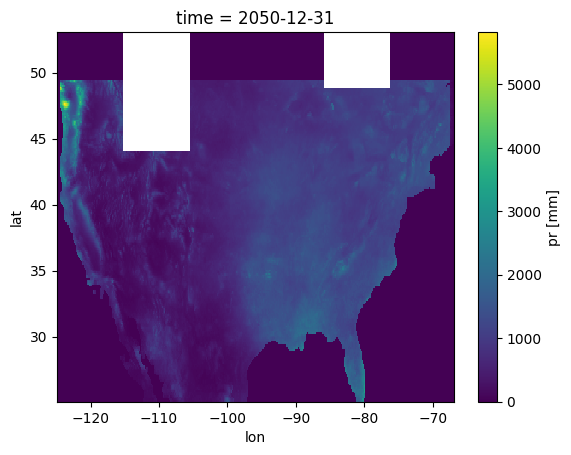

In [60]:
ds.isel(time=100)['pr'].plot()

In [57]:
np.all(ds['slope'] != ds['slope'].to_numpy()[0,0])

<xarray.DataArray 'slope' ()> Size: 1B
array(False)

In [12]:
ds = xr.open_dataset('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/metrics/GARD-LENS/avg_tas_ecearth3_r130i1p1f1_ssp370.nc')

In [43]:
y = ds['tas'].isel(time=0).fillna(0.0)

In [45]:
y

<xarray.DataArray 'tas' (lat: 224, lon: 464)> Size: 416kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 1970-12-31
  * lat      (lat) float32 896B 25.12 25.25 25.38 25.5 ... 52.75 52.88 53.0
  * lon      (lon) float32 2kB -124.9 -124.8 -124.6 ... -67.25 -67.12 -67.0
Attributes:
    description:  predicted mean value

In [42]:
np.all(y == y[0,0])

True

In [3]:
# Fit all: cities
for city in city_list:
    for metric_id in metric_ids:
        tu.trend_fit_city(metric_id, city)

## Regridding

In [31]:
%%time
# Regrid to LOCA using NN
method = "nearest"
target = "LOCA2"

for metric_id in metric_ids:
    # Save path
    store_path = f"{project_data_path}/trends/loca_grid/{metric_id}"
    # Get all files
    files = glob(f"{project_data_path}/trends/original_grids/{metric_id}/STAR-ESDM*") + \
            glob(f"{project_data_path}/trends/original_grids/{metric_id}/GARD-LENS*")

    # Loop through
    for file in files:
        # Check if done
        file_name = file.split('/')[-1]
        store_name = file_name.replace(".nc", f"_{method}.nc")
        if not os.path.exists(f"{store_path}/{store_name}"):
            try:
                # Regrid and store
                ds_tmp = xr.open_dataset(file)
                ds_out = regrid(ds_tmp, method=method, target=target)
                ds_out.to_netcdf(f"{store_path}/{store_name}")
            except Exception as e:
                print(file)

CPU times: user 74.9 ms, sys: 41.6 ms, total: 116 ms
Wall time: 441 ms


In [32]:
%%time
# Regrid to GARD-LENS using NN
method = "nearest"
target = "GARD-LENS"

for metric_id in metric_ids:
    # Save path
    store_path = f"{project_data_path}/trends/gard_grid/{metric_id}"
    # Get all files
    files = glob(f"{project_data_path}/trends/original_grids/{metric_id}/STAR-ESDM*") + \
            glob(f"{project_data_path}/trends/original_grids/{metric_id}/LOCA2*")

    # Loop through
    for file in files:
        # Check if done
        file_name = file.split('/')[-1]
        store_name = file_name.replace(".nc", f"_{method}.nc")
        if not os.path.exists(f"{store_path}/{store_name}"):
            try:
                # Regrid and store
                ds_tmp = xr.open_dataset(file)
                ds_out = regrid(ds_tmp, method=method, target=target)
                ds_out.to_netcdf(f"{store_path}/{store_name}")
            except Exception as e:
                print(file)

CPU times: user 48 s, sys: 9.73 s, total: 57.7 s
Wall time: 1min 43s
